## 0. Import Libraries

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
## using CUDA to speed up training
USE_CUDA = True

## project utils
## basic parameters and pre-processing function 
from preprocess import *
from model import test_model, get_model

## 1. pre-process 

In [2]:
voc, pairs = prepare_data('summary', 'sentence', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 334 sentence pairs
Trimmed to 332 sentence pairs
Indexing words...
['nearly years behind the times the house voted friday to condemn the nazi soviet nonaggression pact of . the measure a nonbinding resolution was brought to the floor by rep . john shimkus r ill . house leaders allowed the measure to be brought to the floor as a way to appease the more conservative members who believe they have been shortchanged by the budget process .', 'house republicans using idle time to get votes on topics good for campaigns']


## 2. test model

In [3]:
test_model()

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


## 3. train model 

In [4]:
from train import train, as_minutes, time_since

In [5]:
## Get model
encoder,decoder = get_model(voc)
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

In [6]:
## Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [7]:
## Train parameters
n_epochs = 5000
plot_every = 20
print_every = 100
## Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [8]:
## Begin!
for epoch in range(1, n_epochs + 1):
    ## Get training data for this cycle
    training_pair = variables_from_pair(voc,random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    ## Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    ## Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    if epoch == 0: continue
    ## Output summary
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
    ## Prepare plot data
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 43s (- 35m 34s) (100 2%) 4.7547
1m 31s (- 36m 27s) (200 4%) 4.5925
2m 28s (- 38m 49s) (300 6%) 5.7171
3m 26s (- 39m 30s) (400 8%) 5.6168
4m 27s (- 40m 11s) (500 10%) 6.0397
5m 24s (- 39m 41s) (600 12%) 5.6340
6m 25s (- 39m 26s) (700 14%) 5.5206
7m 23s (- 38m 48s) (800 16%) 5.3534
8m 23s (- 38m 13s) (900 18%) 5.3379
9m 25s (- 37m 43s) (1000 20%) 5.5464
10m 26s (- 37m 0s) (1100 22%) 5.4568
11m 26s (- 36m 15s) (1200 24%) 5.3155
12m 24s (- 35m 18s) (1300 26%) 5.1650
13m 25s (- 34m 32s) (1400 28%) 5.1918
14m 26s (- 33m 42s) (1500 30%) 5.1907
15m 27s (- 32m 50s) (1600 32%) 4.8732
16m 26s (- 31m 55s) (1700 34%) 4.7738
17m 27s (- 31m 2s) (1800 36%) 4.9720
18m 31s (- 30m 13s) (1900 38%) 4.8969
19m 31s (- 29m 17s) (2000 40%) 4.6841
20m 32s (- 28m 22s) (2100 42%) 4.6163
21m 32s (- 27m 25s) (2200 44%) 4.6084
22m 34s (- 26m 30s) (2300 46%) 4.4909
23m 35s (- 25m 33s) (2400 48%) 4.4909
24m 36s (- 24m 36s) (2500 50%) 4.3825
25m 36s (- 23m 38s) (2600 52%) 4.3635
26m 37s (- 22m 41s) (2700 54%) 4.1986

### save model

In [9]:
encoder_path = './model/encoder.model'
decoder_path = './model/decoder.model'
torch.save(encoder, encoder_path)
torch.save(decoder, decoder_path)
# encoder = torch.load(encoder_path)
# decoder = torch.load(decoder_path)

### show learning curve 

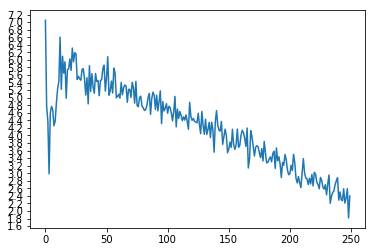

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

## 4. evaluate

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
from utils import evaluate_randomly

In [12]:
evaluate_randomly(encoder, decoder, voc, pairs)

> brief biography of ariel sharon named israel s foreign minister born in kfar mallal in british ruled palestine . mideast war fights as junior officer wounded three times . as a result sharon resigns as defense minister and holds only second rank posts for next years .
= seasoned warrior ariel sharon chosen to seek peace
< seasoned ariel ariel sharon chosen to peace to peace <EOS>



## 5. show attention

In [13]:
from utils import evaluate_and_show_attention

In [14]:
sentence = "a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared ."

input = a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .
output = ecevit warrior for bosnian for . of despite north korea <EOS>


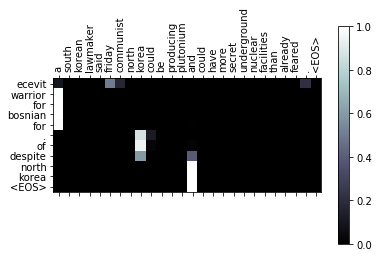

In [15]:
evaluate_and_show_attention(encoder, decoder, voc, sentence)

## 6. generate result on test set

In [16]:
from utils import generate_result

In [17]:
ref_file = './data/extractive_ouput/test_output.txt'
res_file = './data/abstractive_output/test_result.txt'
generate_result(encoder, decoder, voc, ref_file, res_file)

### calculate ROUGE socre

In [18]:
from evaluation import evaluate_rouge_scores

In [19]:
evaluate_rouge_scores(res_file)

38 entries...
38 entries are used for evaluation.


{'ROUGE-1': 0.00518, 'ROUGE-2': 0.0, 'ROUGE-SU4': 0.00101}